In [7]:
import json

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from datasets import get_CIFAR10, get_SVHN, postprocess
from model import Glow


device = torch.device("cuda")

output_folder = 'output/'
model_name = './weights/glow/glow_affine_coupling.pth'

conf = OmegaConf.load('config.yaml')    

image_shape, num_classes, _, test_cifar = get_CIFAR10(conf.augment, conf.dataroot, conf.download)
image_shape, num_classes, _, test_svhn = get_SVHN(conf.augment, conf.dataroot, conf.download)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../../../data/SVHN/train_32x32.mat
Using downloaded and verified file: ../../../data/SVHN/test_32x32.mat


In [2]:
conf.augment

True

In [5]:
conf.K = 32
conf.L = 3
conf.LU_decomposed = True
conf.learn_top = True

In [9]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

model.load_state_dict(torch.load(model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

In [10]:
def sample(model):
    with torch.no_grad():
        if conf.y_condition:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=1, reverse=True))
    return images.cpu()

(-0.5, 205.5, 171.5, -0.5)

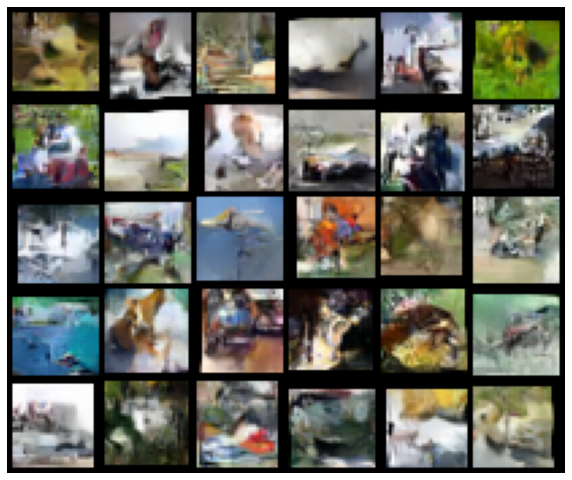

In [11]:
images = sample(model)
grid = make_grid(images[:30], nrow=6, normalize=False).permute(1,2,0).numpy()

plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')